This code is for Julia whose version is higher than 0.6.x.

# Dynamical Mean Field Theory (DMFT) with the continuous-time auxiliary-field Quantum Monte Carlo solver in the Bethe lattice

We calculate the Green's function with the DMFT in the Bethe lattice. The impurity solver is the continuous-time auxiliary-field Quantum Monte Carlo method (CTAUX).   
The subroutine of the CTAUX is ctaux.jl.  
The subroutine of the DMFT is DMFT.jl.  
To obtain the density of states, we use the numerical analytical continuation with the use of the sparse modeling technique (smac.jl).

The local Green's function in the Bethe lattice is expressed as 
\begin{equation}
G_{\rm loc}(i \omega_n) = \sum_k \frac{1}{i \omega_n -\epsilon_k + \mu - \Sigma(\omega_n)}, 
\end{equation}
\begin{equation}
= \int d\epsilon \frac{\rho_0(\epsilon)}{i \omega_n - \epsilon+\mu - \Sigma(\omega_n)}=K_0(i \omega_n + \mu - \Sigma(\omega_n)),
\end{equation}
Here, 
\begin{equation}
\rho_0(\epsilon) = \frac{2}{\pi D} \sqrt{1 - \left(\frac{\epsilon}{D} \right)^2},
\end{equation}
\begin{equation}
K_0(z) = \frac{2}{D} \left[ \frac{z}{D} - i {\rm sgn}(z'') \sqrt{1- \left(\frac{z}{D} \right)^2} \right],
\end{equation}
$z''$ is an imaginary part of $z$.
The function $K_0(z)$ has the relation: 
\begin{equation}
K_0(z)^{-1} = z - \frac{D^2}{4} K_0(z).
\end{equation}


The bath Green's function is expressed as 
\begin{equation}
{\cal G}(i \omega_n)^{-1} = i \omega_n - E_f - \Delta(\omega_n)
\end{equation}
Here, $\Delta(\omega_n)$ is the hybridization function between the local and bath electrons. 
This Green's function is also expressed as 
\begin{equation}
{\cal G}(i \omega_n)^{-1} = G_f(\omega_n)^{-1} + \Sigma_f(\omega_n)
\end{equation}
In the Bethe lattice, this becomes
\begin{equation}
{\cal G}(i \omega_n) =K_0(i \omega_n + \mu - \Sigma_f(\omega_n))^{-1} + \Sigma_f(\omega_n) , 
\end{equation}
\begin{equation}
= i \omega_n + \mu - \Sigma_f(\omega_n) - \frac{D^2}{4}K_0(i \omega_n + \mu - \Sigma_f(\omega_n)) + \Sigma_f(\omega_n),
\end{equation}
\begin{equation}
= i \omega_n + \mu - \frac{D^2}{4}K_0(i \omega_n + \mu - \Sigma_f(\omega_n)).
\end{equation}
Thus, we obtain
\begin{equation}
E_f = - \mu 
\end{equation}
\begin{equation}
\Delta(\omega_n) =  \frac{D^2}{4}K_0(i \omega_n + \mu - \Sigma_f(\omega_n))
\end{equation}


The DMFT calculation in the Bethe lattice is as follows. 
1. $\Sigma_f(\omega_n) = 0$.
2. $G_f(i \omega_n) = G_{\rm loc}(i \omega_n) = \sum_k \frac{1}{i \omega_n -\epsilon_k + \mu - \Sigma_f(\omega_n)} = K_0(i \omega_n + \mu - \Sigma_f(\omega_n))$.
3. The hybridization function is $\Delta(\omega_n) =\frac{D^2}{4}K_0(i \omega_n + \mu - \Sigma_f(\omega_n)) = \frac{D^2}{4} G_f(\omega_n)$.
4. Solve the impurity problem with the hybridization function $\Delta(i \omega_n)$ to obtain the Green's function $G_f(\omega_n)$.
5. Go to 3. until the Green's function $G_f(\omega_n)$ is converged. 

In [6]:
include("./DMFT.jl")
using .dmft

β=30.0 #Inverse temperature
U = 2.0 #Density-Density interaction
μ=U/2 #Chemical potential
K = 1.0
mqs = 300000
ntime = 1024 #number of τs
mfreq = 1024 #number of ωns
norbs = 2 #number of orbitals. norbs = 2 for 1-band model.
V = 1.0 #Strength of the hybridization
nthermal = 1000
mkink = 1024

τmesh,Gτ,Gω,ωmesh,Δ=dmft.dmft_solver(β,U,μ,K,mqs,ntime,mfreq,norbs,V,nthermal,mkink,10,0.3)

println("DMFT loops are done.")

println("The final CTAUX calculation starts.")
mqs = mqs*10
τmesh,Gτ,orderdisp,S,Gω,ωmesh = dmft.ctaux_solver_general(Δ,β,U,μ,K,mqs,ntime,mfreq,norbs,V,nthermal,mkink,false)
println("End.")


┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1186


-----------------------------------------------------------------
--Dynamical Mean Field Theory for the Bethe lattice            --
--                                                             --
--                      Yuki Nagai, Ph.D 12/15/2017(MM/DD/YY)  --
--       The code works with Julia 0.7.0 08/09/2018(MM/DD/YY)  --
-----------------------------------------------------------------
-----------------------------------------------------------------
DMFT: Initial calculation
------------------------------------------------------
--Continuous-time auxiliary-field Monte Carlo method--
--                       for quantum impurity models--
--                                                  --
--         See, E. Gull et al., EPL 82, 57003 (2008)--
--             Yuki Nagai, Ph.D 10/24/2017(MM/DD/YY)--
------------------------------------------------------
Parameters
Inverse temperature: β = 30.0
Density-Density interaction: U = 2.0
Chemical potential: μ = 1.0
Parameter 'K': K = 1.

In [8]:
using Plots
gr()

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


Plots.GRBackend()

## The Green's function

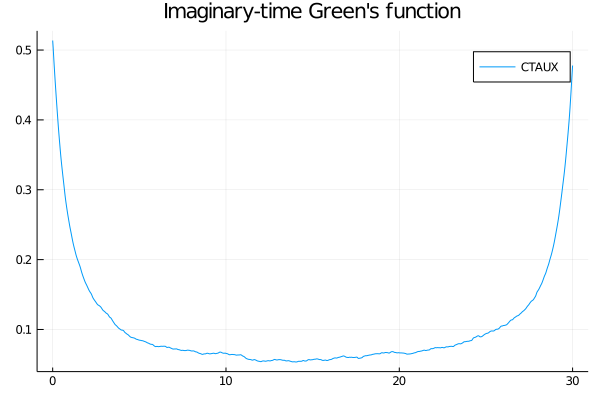

In [9]:
plot(τmesh[:],Gτ[:,1],label="CTAUX",title="Imaginary-time Green's function")

## Numerical analytic continuation
We use the SMAC, the method of the numerical analytic continuation, to obtain the density of states.

In [10]:
include("./smac.jl")
using .Smac
omegamax = 5.0
M = ntime
N = 256
vec_Gout = zeros(Float64,M,1)
xout = zeros(Float64,N,1)

omegas = zeros(Float64,N)
dω = 2omegamax/(N-1)
for i in 1:N
    omegas[i] = (i-1)*dω - omegamax
end


@time (xout,vec_Gout) = Smac.smac_main!(M,N,1,omegamax,β,Gτ)

Making the matrix K...
done.
Doing SVD...
done.
---------------------------------------------
Singular values
1	43.89031875003307
2	38.493754209473884
3	25.710235534593142
4	18.063773311695645
5	11.297535673262026
6	7.055998221685022
7	4.229597177225385
8	2.4895131883905313
9	1.431247390400766
10	0.8070967345612823
11	0.44647741905714533
12	0.24257513573083928
13	0.1295083182812183
14	0.06798531284030401
15	0.03510520475235151
16	0.01783804822915472
17	0.008921936062331848
18	0.004393849198931381
19	0.0021309931780773613
20	0.0010180813549117381
21	0.0004791750243385267
22	0.00022223562286883557
23	0.00010157033012839186
24	4.57552046889758e-5
25	2.031623017193097e-5
26	8.893161040342729e-6
27	3.837724836034546e-6
28	1.6329600386434297e-6
29	6.850832325561532e-7
30	2.834373883910745e-7
31	1.1563469377678814e-7
32	4.652849281742294e-8
33	1.8463369152015454e-8
34	7.226883457871499e-9
35	2.7899172877363036e-9
36	1.0624893570323789e-9
37	3.99111190921226e-10
38	1.4791053447157003e-10
39	5.

([-2.20289e-7; 2.97336e-7; … ; 3.34114e-5; 4.15781e-5], [0.517802; 0.503232; … ; 0.468261; 0.482198])

## Energy dependence of the density of states

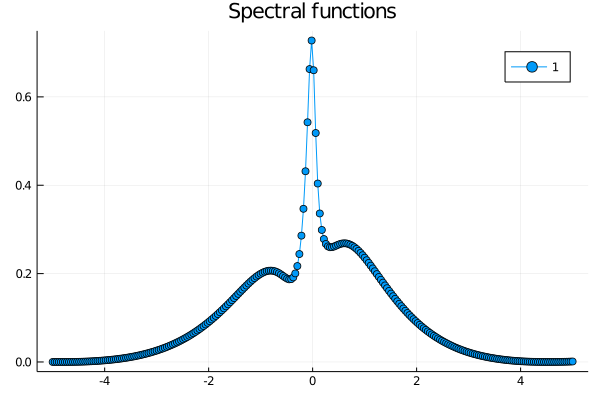

In [11]:
plot(omegas[:],xout[:,1]/dω,label="1",title="Spectral functions", marker=:circle)

We need more accurate Green's function. 

We symmetrize the Green's function to remove the real part of the $G(i \omega_n)$.

In [13]:
include("ctaux.jl")
using .Ctauxsolver
Gτ = symmetrize(Gω,τmesh,ωmesh,norbs,mfreq,ntime,β)
plot(τmesh[:],Gτ[:,1],label="CTAUX",title="Imaginary-time Green's function")

BoundsError: BoundsError: attempt to access 1024×2×2 Array{Float64,3} at index [Base.Slice(Base.OneTo(1024)), 1]

Making the matrix K...
done.
Doing SVD...
done.
---------------------------------------------
Singular values
1	43.89031875003307
2	38.493754209473884
3	25.710235534593142
4	18.063773311695645
5	11.297535673262026
6	7.055998221685022
7	4.229597177225385
8	2.4895131883905313
9	1.431247390400766
10	0.8070967345612823
11	0.44647741905714533
12	0.24257513573083928
13	0.1295083182812183
14	0.06798531284030401
15	0.03510520475235151
16	0.01783804822915472
17	0.008921936062331848
18	0.004393849198931381
19	0.0021309931780773613
20	0.0010180813549117381
21	0.0004791750243385267
22	0.00022223562286883557
23	0.00010157033012839186
24	4.57552046889758e-5
25	2.031623017193097e-5
26	8.893161040342729e-6
27	3.837724836034546e-6
28	1.6329600386434297e-6
29	6.850832325561532e-7
30	2.834373883910745e-7
31	1.1563469377678814e-7
32	4.652849281742294e-8
33	1.8463369152015454e-8
34	7.226883457871499e-9
35	2.7899172877363036e-9
36	1.0624893570323789e-9
37	3.99111190921226e-10
38	1.4791053447157003e-10
39	5.

1/18	λ:2.335721469090121e-6		Error:0.0023119816916901226	
2/18	λ:5.455594781168514e-6		Error:0.002318218460160535	
3/18	λ:1.2742749857031348e-5		Error:0.0023245729838280473	
4/18	λ:2.9763514416313192e-5		Error:0.0023293025107373327	
5/18	λ:6.951927961775606e-5		Error:0.002330154440327316	
6/18	λ:0.00016237767391887227		Error:0.0023405074726651235	
7/18	λ:0.000379269019073225		Error:0.002389547159650483	
8/18	λ:0.0008858667904100823		Error:0.0024671011806685966	
9/18	λ:0.00206913808111479		Error:0.0024843742136532046	
10/18	λ:0.004832930238571752		Error:0.0025445369567721533	
11/18	λ:0.011288378916846883		Error:0.0025950516769267817	
12/18	λ:0.026366508987303607		Error:0.0026739451454122765	
13/18	λ:0.06158482110660267		Error:0.0030971622286810247	
14/18	λ:0.14384498882876628		Error:0.004640463472716848	
15/18	λ:0.3359818286283781		Error:0.0067641777178191875	
16/18	λ:0.7847599703514607		Error:0.012560522079578989	
17/18	λ:1.8329807108324374		Error:0.013227637685378397	
18/18	λ:4.281332

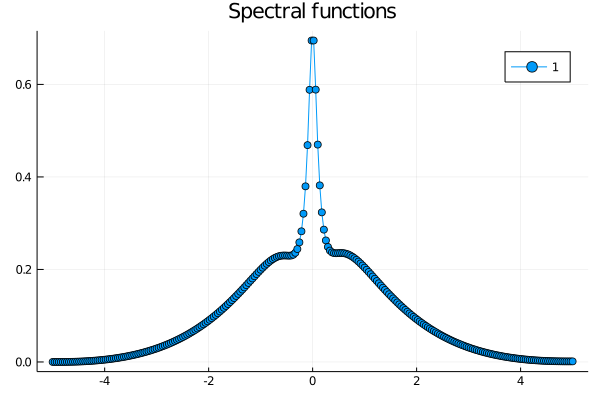

In [14]:
include("./smac.jl")
using .Smac
omegamax = 5.0
M = ntime
N = 256
vec_Gout = zeros(Float64,M,1)
xout = zeros(Float64,N,1)

omegas = zeros(Float64,N)
dω = 2omegamax/(N-1)
for i in 1:N
    omegas[i] = (i-1)*dω - omegamax
end


@time (xout,vec_Gout) = Smac.smac_main!(M,N,1,omegamax,β,Gτ)

plot(omegas[:],xout[:,1]/dω,label="1",title="Spectral functions", marker=:circle)